# Assignment 2
## Part 2: Scale-Space Blob Construction   
Mohammad Rashiqul Alam  
malam25@illinois.edu  

In [39]:
# Modules
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image
from scipy.ndimage import gaussian_filter, gaussian_laplace, sobel
from skimage import filters, feature, util, color
from skimage.transform import resize

## Image Pre-Processing

### Import All ALigned Images
Import low-resolution images from ~/Gen/a2/lowres_rgb/preprocessed  
Import high-resolution images from ~/Gen/a2/hires_rgb/preprocessed

**Notebook assumes the output has been generated froma alam_rashiqul_a2_p1.pynb

In [40]:
# Import aligned images to notebook
def import_aligned_images(path, ext='jpg'):
    """
    Function to import aligned images from a specified directory, 
    only those ending with *_aligned.jpg.
    Args:
    - path: str, path to the directory containing images
    - ext: str, file extension of the images to import (default: 'jpg')
    Returns:
    - images: list of numpy arrays (each image)
    """
    images = []
    for file in os.listdir(path):
        if file.endswith(f"_aligned.{ext}"):
            img = Image.open(os.path.join(path, file))
            images.append(np.array(img))
    return images

# Plot aligned images
def plot_aligned_images(images, filenames=None, use_gray=False):
    """
    Function to plot all aligned images from the dataset.
    Args:
        images: list of numpy arrays (each image)
        filenames: list of filenames corresponding to images (optional)
        use_gray: bool, if True use grayscale colormap
    Returns:
        None
    """
    n = len(images)
    plt.figure(figsize=(2.5 * n, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        if use_gray:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.axis("off")
        if filenames:
            name = filenames[i].replace('_aligned.jpg', '').replace('_aligned.jpeg', '').replace('_aligned.png', '')
            ax.set_title(name, fontsize=10)
    plt.show()

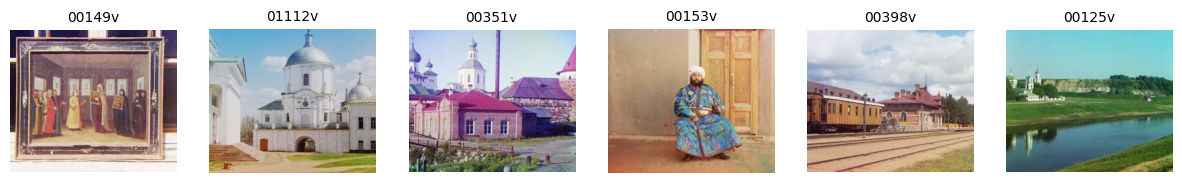

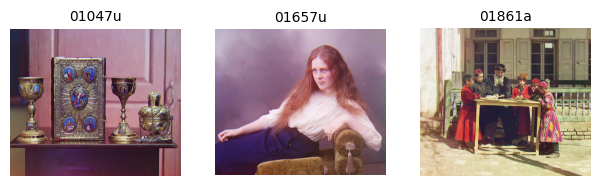

In [41]:
# Get the directory one level above the notebook location
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
lowres_preproc_dir = os.path.join(parent_dir, "Gen", "a2", "lowres_rgb", "preprocessed")
highres_preproc_dir = os.path.join(parent_dir, "Gen", "a2", "hires_rgb", "preprocessed")

# Import low-res images
low_res_images = import_aligned_images(lowres_preproc_dir, ext='jpg')
# Get filenames for low-res images
low_res_filenames = [f for f in os.listdir(lowres_preproc_dir) if f.endswith("_aligned.jpg")]
# Import high-res images
high_res_images = import_aligned_images(highres_preproc_dir, ext='jpg')
# Get filenames for high-res images
high_res_filenames = [f for f in os.listdir(highres_preproc_dir) if f.endswith("_aligned.jpg")]

# Plot images
plot_aligned_images(low_res_images, low_res_filenames, use_gray=False)
plot_aligned_images(high_res_images, high_res_filenames, use_gray=False)

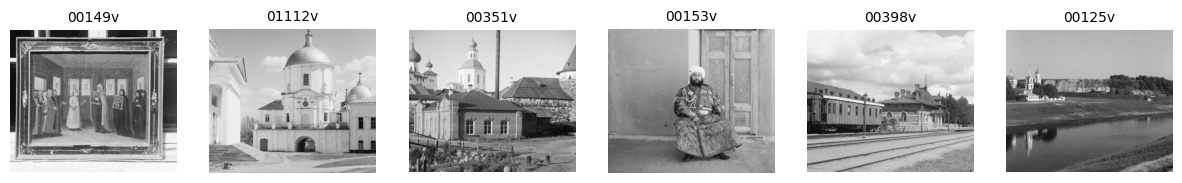

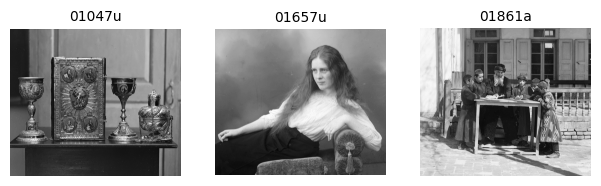

In [42]:
# Convert images to grayscale and rescale intensities to [0, 1]
low_res_gray = [np.array(Image.fromarray(img).convert('L')) / 255.0 for img in low_res_images]
high_res_gray = [np.array(Image.fromarray(img).convert('L')) / 255.0 for img in high_res_images]

# Plot gray-scale images
plot_aligned_images(low_res_gray, low_res_filenames, use_gray=True)
plot_aligned_images(high_res_gray, high_res_filenames, use_gray=True)

### Choice of Images for Part 2: Scale-Space Blob Construction

Selected four aligned images for this part of the assignment:
1. **00125v_aligned.jpg (Church by river)**  
   - Contains both natural features (trees, cliffs, river) and man-made structures (church buildings).  
   - Provides a mix of sharp corners and smoother regions, useful for testing corner detection and blob scale behavior.
2. **00351v_aligned.jpg (Brick house with domes)**  
   - Rich in architectural detail with windows, rooftops, and domes.  
   - Good distribution of corners and circular blob-like features at different scales.
3. **00398v_aligned.jpg (Train station with train cars)**  
   - Strong geometric patterns from train cars, station buildings, and tracks.  
   - Tests whether the method correctly preserves scale/orientation across repeating man-made structures.
4. **01047u_aligned.jpg (Chalices and book)**  
   - Objects with fine texture and small-scale blob-like details (ornamental designs, circular cups).  
   - Complements the larger-scale features in the other images with smaller, high-detail regions.

Selected image keys: dict_keys(['00125v', '00351v', '00398v', '01047u'])


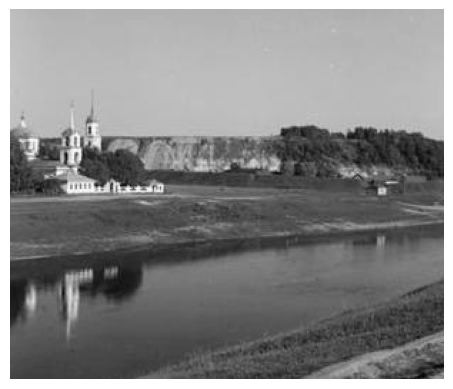

00125v


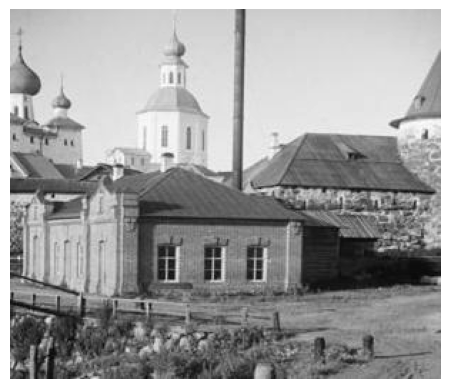

00351v


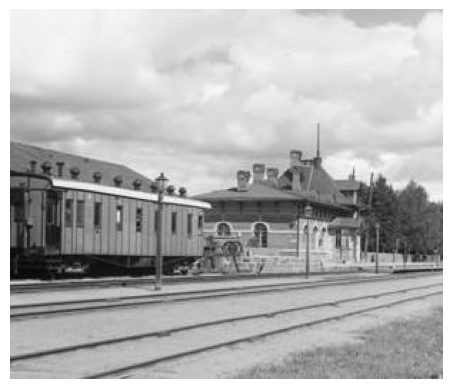

00398v


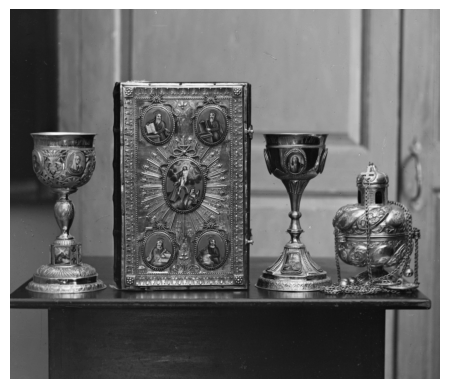

01047u


In [43]:
selected_names = [
    "00125v_aligned.jpg",
    "00351v_aligned.jpg",
    "00398v_aligned.jpg",
    "01047u_aligned.jpg"
]

# Build the dictionary
selected_images_dict = {}

# Add low-res and high-res images to the dictionary
for name in selected_names:
    key = name.replace('_aligned.jpg', '')
    # Try to find in high-res first
    if name in high_res_filenames:
        idx = high_res_filenames.index(name)
        selected_images_dict[key] = high_res_gray[idx]
    # If not found, try low-res
    elif name in low_res_filenames:
        idx = low_res_filenames.index(name)
        selected_images_dict[key] = low_res_gray[idx]
    else:
        print(f"Warning: {name} not found in either low-res or high-res images.")

# Print the keys of the selected images dictionary
print("Selected image keys:", selected_images_dict.keys())

# Plot the images
for name, image in selected_images_dict.items():
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()
    print(f"{name}")

## Build a Harris-Corner Detector
### Harris Corner Detector (based on textbook, Section 8.2.1)

Corners are a special type of **interest point**:  
- In a flat region → gradients are small in every direction.  
- Along an edge → there is a strong gradient, but only in **one** direction.  
- At a corner → there are strong gradients in **two different directions**, so the local patch cannot be slid around without changing the image content.

The Harris detector formalizes this by looking at the **second moment matrix** (also called the structure tensor) in a small neighborhood:

$$
H = \sum_{\text{window}}
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2
\end{bmatrix}
$$
  
where $I_x, I_y$ are image gradients.

**Steps:**
1. **Compute image gradients**  
   Use derivative filters (e.g., Sobel or derivative of Gaussian) to obtain $I_x$ and $I_y$.

2. **Form the structure tensor**  
   Build the matrix $H$ from $I_x^2$, $I_y^2$, $I_x I_y$.  
   Smooth these terms with a Gaussian window so that the tensor reflects a local neighborhood rather than a single pixel.

3. **Analyze eigenvalues of \(H\)**  
   - If both eigenvalues are small → flat region.  
   - If one eigenvalue is large, one small → edge.  
   - If both are large → corner. :contentReference[oaicite:0]{index=0}

4. **Corner response function**  
   Instead of explicitly computing eigenvalues, Harris proposed a simple test:  
   $$
   R = \det(H) - k \cdot (\text{trace}(H))^2
   $$
   where $k$ is a constant (typically $\sim 0.04$–$0.06$).  
   Large positive values of $R$ indicate likely corners.

5. **Find local maxima**  
   Search the response map $R$ for local peaks above a threshold. 
   These become the final **corner points**.

**Key properties:**
- Harris corners are **covariant to translation and rotation** (the same points appear when the image shifts or rotates).
- They are sensitive to **contrast** (stronger response at high-contrast corners).
- They provide a compact set of distinctive, localizable points for further processing.


In [44]:
# Default harris corner detection configurations
harris_configs = dict(
    sigma_grad=1.0,       # Gaussian smoothing scale for gradient estimation
    sigma_window=1.5,     # Gaussian window scale for structure tensor
    k=0.04,               # Harris detector free parameter (typically 0.04–0.06)
    min_distance=6,       # Minimum separation between detected corners (pixels)
    threshold_rel=0.005,  # Relative threshold for peak selection (fraction of max R)
    max_peaks=750         # Maximum number of corners to return
)

In [45]:
def compute_image_gradients(image, *, sigma_grad=1.0):
    """
    Estimate image gradients grad_x, grad_y.
    Args:
    - image: 2D numpy array (grayscale image)
    - sigma_grad: float, standard deviation for Gaussian smoothing
    Returns:
    - grad_x: 2D numpy array, gradient in x direction
    - grad_y: 2D numpy array, gradient in y direction
    """
    smoothed_image = filters.gaussian(image, sigma=sigma_grad, preserve_range=True, mode='reflect')
    grad_x = filters.sobel_h(smoothed_image)   # ∂I/∂x
    grad_y = filters.sobel_v(smoothed_image)   # ∂I/∂y
    return grad_x, grad_y

def compute_structure_tensor(grad_x, grad_y, *, sigma_window=1.5):
    """
    Build and smooth second-moment (structure) tensor entries in a local window.
      A = Gsigma * (grad_x^2),  B = Gsigma * (grad_y^2),  C = Gsigma * (grad_x*grad_y)
      where Gsigma is a Gaussian with sigma_window.
    Args:
    - grad_x: 2D numpy array, gradient in x direction
    - grad_y: 2D numpy array, gradient in y direction
    - sigma_window: float, standard deviation for Gaussian smoothing of tensor entries
    Returns:
    - tensor_xx: 2D numpy array, smoothed grad_x^2
    - tensor_yy: 2D numpy array, smoothed grad_y^2
    - tensor_xy: 2D numpy array, smoothed grad_x * grad_y
    """
    grad_xx = grad_x * grad_x
    grad_yy = grad_y * grad_y
    grad_xy = grad_x * grad_y

    tensor_xx = filters.gaussian(grad_xx, sigma=sigma_window, preserve_range=True, mode='reflect')
    tensor_yy = filters.gaussian(grad_yy, sigma=sigma_window, preserve_range=True, mode='reflect')
    tensor_xy = filters.gaussian(grad_xy, sigma=sigma_window, preserve_range=True, mode='reflect')
    return tensor_xx, tensor_yy, tensor_xy

def compute_harris_response(tensor_xx, tensor_yy, tensor_xy, *, k=0.04):
    """
    Harris response:
      det(H) - k * (trace(H))^2
      with H = [[tensor_xx, tensor_xy], [tensor_xy, tensor_yy]]
    Large positive R => likely corner (both eigenvalues large).
    Args:
    - tensor_xx: 2D numpy array, smoothed grad_x^2
    - tensor_yy: 2D numpy array, smoothed grad_y^2
    - tensor_xy: 2D numpy array, smoothed grad_x * grad_y
    - k: float, Harris detector free parameter (typically 0.04 - 0.06)
    Returns:
    - response: 2D numpy array, Harris corner response map
    """
    det_H   = tensor_xx * tensor_yy - tensor_xy * tensor_xy
    trace_H = tensor_xx + tensor_yy
    response = det_H - k * (trace_H ** 2)
    return response

def select_harris_corners(response, *, min_distance=6, threshold_rel=0.01, max_peaks=500):
    """
    Local maxima in response above relative threshold; enforce spatial separation.
    Returns Nx2 coordinates as (row=y, col=x).
    Args:
    - response: 2D numpy array, Harris corner response map
    - min_distance: int, minimum number of pixels separating peaks
    - threshold_rel: float, relative threshold for peak selection (fraction of max response)
    - max_peaks: int, maximum number of peaks to return
    Returns:
    - corner_coords: Nx2 numpy array of (row, col) coordinates of detected corners
    """
    corner_coords = feature.peak_local_max(
        response,
        min_distance=min_distance,
        threshold_rel=threshold_rel,
        num_peaks=max_peaks
    )
    return corner_coords

In [46]:
# Harris corner detection function
def harris_corner_detector(
    image, 
    sigma_grad=1.0, 
    sigma_window=1.5, 
    k=0.04, 
    min_distance=6, 
    threshold_rel=0.01, 
    max_peaks=500
):
    """
    Function to perform Harris corner detection on a grayscale image.
    Args:
        image: 2D numpy array, input grayscale image
        sigma_grad: float, Gaussian smoothing scale for gradient estimation
        sigma_window: float, Gaussian window scale for structure tensor
        k: float, Harris detector free parameter (typically 0.04–0.06)
        min_distance: int, minimum separation between detected corners (pixels)
        threshold_rel: float, relative threshold for peak selection (fraction of max R)
        max_peaks: int, maximum number of corners to return
    Returns:
        harris_response: 2D numpy array, Harris response image
        corner_coords: Nx2 numpy array, coordinates of detected corners (row, col)
    """
    # Step 1: Compute image gradients
    grad_x, grad_y = compute_image_gradients(image, sigma_grad=sigma_grad)
    # Step 2: Compute structure tensor components
    tensor_xx, tensor_yy, tensor_xy = compute_structure_tensor(grad_x, grad_y, sigma_window=sigma_window)
    # Step 3: Compute Harris response
    harris_response = compute_harris_response(tensor_xx, tensor_yy, tensor_xy, k=k)
    # Step 4: Select corners from the response
    corner_coords = select_harris_corners(
        harris_response, 
        min_distance=min_distance, 
        threshold_rel=threshold_rel, 
        max_peaks=max_peaks
    )
    # Return response and coordinates
    return harris_response, corner_coords

In [47]:
def plot_corner_overlay(image, corner_coords, title="Harris corners"):
    """
    Overlay detected corners on the image.
    Args:
        image: 2D numpy array, grayscale image
        corner_coords: Nx2 numpy array, coordinates of detected corners (row, col)
        title: str, plot title
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray')
    if len(corner_coords) > 0:
        ax.plot(corner_coords[:, 1], corner_coords[:, 0], 'r.', markersize=3)
    ax.set_title(f"{title} — {len(corner_coords)} corners")
    ax.axis('off')
    plt.show()

In [48]:
# Entry function for Harris corner detection
def run_harris_on_selected_images(selected_images_dict, show=True):
    """
    Function to run harris corner detection on selected images.
    Args:
        selected_images_dict: dictionary containing selected images
        show: if True display the results
    Returns:
        results: dictionary with Harris corner detection results
    """
    results = {}
    for name, image in selected_images_dict.items():
        harris_response, corner_coords = harris_corner_detector(image, **harris_configs)
        if show:
            plot_corner_overlay(image, corner_coords, title=f"{name}")
        results[name] = {'response': harris_response, 'coords': corner_coords}
    return results

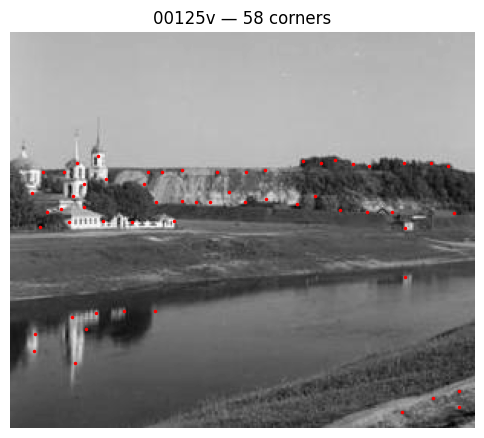

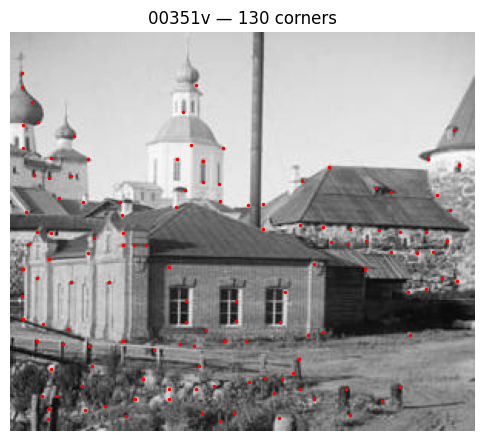

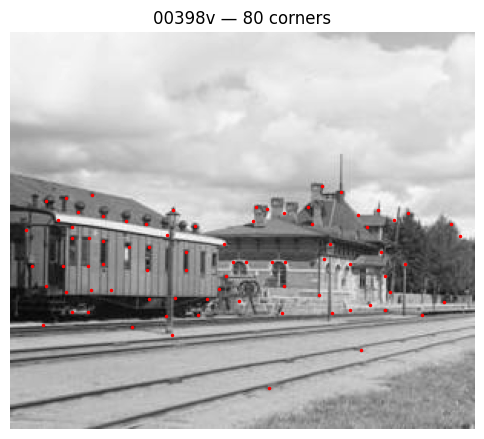

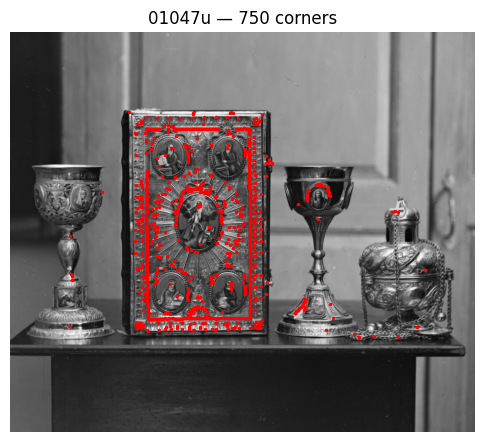

00125v corners: 58
00351v corners: 130
00398v corners: 80
01047u corners: 750


In [49]:
# Run Harris corner detection on selected images
harris_results = run_harris_on_selected_images(selected_images_dict, show=True)

# Print number of corners detected in each image
for k, v in harris_results.items():
    print(k, "corners:", len(v['coords']))

### Scale-Space Blob Detection (based on textbook, Section 8.2.2)
**Scale Pyramid:**  
Construct a set of scales:
$$
\sigma_i = \sigma_0 \cdot k^i \quad (i = 0, 1, \ldots, L-1)
$$
Typical values:  
$$
\sigma_0 \approx 2, \quad L = 10\text{–}15
$$

**Scale-Normalized LoG:**  
For each scale \(\sigma\), compute:
$$
R_\sigma = \sigma^2 \cdot \nabla^2 G_\sigma * I
$$
using `scipy.ndimage.gaussian_laplace`. The $\sigma^2$ factor ensures fair comparison across scales.

**Response Sampling at Corners:**  
At each Harris corner coordinate, record the LoG response for all scales in the pyramid.

**Characteristic Scale Selection:**  
For each corner, pick the scale that maximizes the absolute response $|R_\sigma|$..

**Sub-Scale Refinement:**  
Apply a quadratic fit in $\log \sigma$ around the discrete maximum to interpolate a more precise characteristic scale.

### Scale Selection via Pyramid LoG

- Build a geometric scale set:  
  $$
  \sigma_\ell = \sigma_0 \, k^\ell, \quad \ell = 0 \dots L-1
  $$

- For each level $\ell$:
    1. Downsample the image by  
       $$
       \text{factor} = \frac{\sigma_0}{\sigma_\ell}
       $$
    2. Apply a fixed-scale LoG at $\sigma_0$ on the downsampled image.
    3. Multiply by $\sigma_\ell^2$ for scale normalization.
    4. Upsample the response back to the original size.

- At every Harris corner, sample the responses across levels and choose the $\sigma_\ell$ that maximizes $|R_\sigma|$.

- Refine the scale by a quadratic fit in $\log \sigma$ around the peak to obtain a sub-level estimate.

In [50]:
def dominant_orientations(img_gray, corner_coords, scales, radius_factor=np.sqrt(2.0), num_bins=36):
    """
    For each corner, compute the dominant gradient orientation in a circular window
    of radius = radius_factor * scale, weighted by gradient magnitude.

    Parameters
    ----------
    img_gray : 2D np.ndarray
        Grayscale image.
    corner_coords : (N, 2) np.ndarray
        Array of (row, col) coordinates for each corner.
    scales : (N,) np.ndarray
        Characteristic scale (sigma) for each corner.
    radius_factor : float
        Multiplier for the window radius (default sqrt(2)).
    num_bins : int
        Number of bins for orientation histogram (default 36).

    Returns
    -------
    orientations : (N,) np.ndarray
        Dominant orientation (in radians, [0, 2π)) for each corner.
    """

    # Compute image gradients (Sobel)
    grad_x = sobel(img_gray, axis=1, mode='reflect')
    grad_y = sobel(img_gray, axis=0, mode='reflect')
    grad_magnitude = np.hypot(grad_x, grad_y)
    grad_angle = (np.arctan2(grad_y, grad_x) + 2 * np.pi) % (2 * np.pi)

    # Precompute meshgrid for window extraction
    img_height, img_width = img_gray.shape
    yy, xx = np.indices((img_height, img_width))
    
    # Compute the number of corners and initialize orientation array
    num_corners = len(scales)
    orientations = np.zeros(num_corners, dtype=np.float32)
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)

    # For each corner, compute the dominant orientation
    for i, ((row, col), sigma) in enumerate(zip(np.round(corner_coords).astype(int), scales)):
        # Define circular window radius
        window_radius = float(radius_factor * sigma)
        
        # Clamp center to image bounds
        row = int(np.clip(row, 0, img_height - 1))
        col = int(np.clip(col, 0, img_width - 1))
        
        # Compute window bounds
        row_min = max(0, int(row - window_radius))
        row_max = min(img_height, int(row + window_radius + 1))
        col_min = max(0, int(col - window_radius))
        col_max = min(img_width, int(col + window_radius + 1))

        # Extract window meshgrid
        window_yy = yy[row_min:row_max, col_min:col_max]
        window_xx = xx[row_min:row_max, col_min:col_max]
        
        # Create circular mask
        # The equation of a circle: (x - h)^2 + (y - k)^2 <= r^2
        mask = (window_yy - row) ** 2 + (window_xx - col) ** 2 <= window_radius ** 2

        # Extract gradient magnitude and angle within the window
        window_magnitude = grad_magnitude[row_min:row_max, col_min:col_max][mask]
        window_angle = grad_angle[row_min:row_max, col_min:col_max][mask]

        # Compute dominant orientation if there are pixels in the window
        if window_magnitude.size != 0:
            # Build weighted orientation histogram
            hist, _ = np.histogram(window_angle, bins=bin_edges, weights=window_magnitude)
            max_bin = int(np.argmax(hist))
            # Assign orientation as the center of the max bin
            orientations[i] = float(0.5 * (bin_edges[max_bin] + bin_edges[max_bin + 1]) % (2 * np.pi))

    return orientations

In [51]:
def refine_blob_scales_quadratic(scales, corner_responses, peak_levels):
    """
    Refine the characteristic scale for each corner using quadratic interpolation in log-scale space.

    Parameters
    ----------
    scales : (L,) np.ndarray
        Array of scale values (sigma) used to build the LoG stack.
    corner_responses : (L, N) np.ndarray
        LoG responses at each scale (L levels) for each of N corners.
    peak_levels : (N,) np.ndarray
        Discrete argmax level (index) per corner, i.e., the scale with the maximum response.

    Returns
    -------
    refined_scales : (N,) np.ndarray
        Refined (possibly sub-level) scale for each corner, using quadratic fit in log(sigma).
    """
    # Number of levels and corners
    num_levels, num_corners = corner_responses.shape
    # Logarithm of scales
    log_scales = np.log(scales)
    # Initialize refined scales with discrete best
    refined_scales = scales[peak_levels].astype(float).copy() 

    # Loop over each corner to refine its scale
    for i in range(num_corners):
        peak_idx = int(peak_levels[i])
        # Only refine if not at the boundary
        if 0 < peak_idx < num_levels - 1:
            # Get log-scales and responses for three neighboring levels
            x = log_scales[[peak_idx - 1, peak_idx, peak_idx + 1]]
            y = corner_responses[[peak_idx - 1, peak_idx, peak_idx + 1], i].astype(float)
            # Fit a parabola: y = a*x^2 + b*x + c
            a, b, _ = np.polyfit(x, y, 2)
            if abs(a) > 1e-12:
                # Vertex of the parabola gives refined log-scale
                refined_log_scale = -b / (2.0 * a)
                # Clamp to the local window
                refined_log_scale = np.clip(refined_log_scale, x.min(), x.max())
                refined_scales[i] = float(np.exp(refined_log_scale))  # Convert back to linear scale

    return refined_scales

In [52]:
def build_scale_space_log_stack(
    image_gray, sigma_base=2.0, scale_multiplier=1.25, num_levels=12
):
    """
    Build a scale-space stack of scale-normalized Laplacian-of-Gaussian (LoG) responses
    using a geometric scale pyramid and anti-aliased downsampling.

    Parameters
    ----------
    image_gray : 2D np.ndarray
        Input grayscale image.
    sigma_base : float
        Base scale (sigma_0) for LoG filtering at each level.
    scale_multiplier : float
        Multiplicative factor (k) between pyramid levels.
    num_levels : int
        Number of pyramid levels (L).

    Returns
    -------
    log_stack : (L, H, W) np.ndarray
        Scale-normalized LoG responses at each level, upsampled to original image size.
    effective_scales : (L,) np.ndarray
        Effective scale (sigma) at each level in original image coordinates.
    """

    # Convert input image to float32 for processing
    image = np.asarray(image_gray, dtype=np.float32, order="C")
    height, width = image.shape

    # Compute geometric scale levels: sigma = sigma_0 * k^level
    levels = np.arange(num_levels, dtype=int)
    effective_scales = sigma_base * (scale_multiplier ** levels)

    # Allocate stack for LoG responses at each scale
    log_stack = np.empty((num_levels, height, width), dtype=np.float32)

    # Process each pyramid level
    for level_idx, sigma in zip(levels, effective_scales):
        # Compute downsampling factor for this level
        downsample_factor = scale_multiplier ** level_idx

        # Compute downsampled image size (ensure at least 1 pixel in each dimension)
        height_ds = max(1, int(round(height / downsample_factor)))
        width_ds = max(1, int(round(width / downsample_factor)))

        # Downsample image with anti-aliasing, preserving intensity range
        image_ds = resize(
            image,
            (height_ds, width_ds),
            preserve_range=True,
            anti_aliasing=True,
            order=1,
        ).astype(np.float32)

        # Apply fixed-scale LoG filter (sigma_0) to downsampled image
        log_response_ds = gaussian_laplace(image_ds, sigma=float(sigma_base), mode="reflect")

        # Upsample LoG response back to original image size (bilinear, no anti-aliasing)
        log_response_up = resize(
            log_response_ds,
            (height, width),
            preserve_range=True,
            anti_aliasing=False,
            order=1,
        ).astype(np.float32)

        # Scale-normalize the response by (sigma)^2
        log_stack[level_idx] = (sigma ** 2) * log_response_up

    return log_stack, effective_scales

In [53]:
def detect_blob_scales(image, corner_coords, sigma0=2.0, k=1.25, num_levels=12, return_stack=False):
    """
    Assign a characteristic scale to each Harris corner using a
    scale-normalized LoG pyramid (fixed sigma0 per level) plus 3-point
    quadratic refinement in log(sigma).

    Parameters
    ----------
    image : 2D np.ndarray
        Input grayscale image.
    corner_coords : (N, 2) np.ndarray
        Harris corner coordinates (row, col).
    sigma0 : float
        Base scale for LoG filtering.
    k : float
        Multiplicative factor between pyramid levels.
    num_levels : int
        Number of pyramid levels.
    return_stack : bool
        If True, also return the full LoG stack and scales.

    Returns
    -------
    sigmas_refined : (N,) np.ndarray
        Refined scales per corner.
    best_levels : (N,) np.ndarray
        Discrete winning level index per corner.
    best_values : (N,) np.ndarray
        Response value at winning level per corner.
    [stack, scales] : optional
        If return_stack=True, also returns (L,H,W) stack and (L,) scales.
    """

    # 1. Build the scale-space LoG stack and get the effective scales
    log_stack, scales = build_scale_space_log_stack(
        image_gray=image,
        sigma_base=sigma0,
        scale_multiplier=k,
        num_levels=num_levels
    )

    # 2. Sample LoG responses at each corner across all scales
    H, W = log_stack.shape[1:]
    corner_coords = np.asarray(corner_coords)
    rows = np.clip(np.round(corner_coords[:, 0]).astype(int), 0, H - 1)
    cols = np.clip(np.round(corner_coords[:, 1]).astype(int), 0, W - 1)
    corner_responses = log_stack[:, rows, cols]  # shape: (L, N)

    # 3. Find the best scale (level) for each corner
    best_levels = np.argmax(corner_responses, axis=0)  # (N,)
    best_values = corner_responses[best_levels, np.arange(corner_responses.shape[1])]

    # 4. Refine the scale using quadratic interpolation in log(sigma)
    sigmas_refined = refine_blob_scales_quadratic(scales, corner_responses, best_levels)

    if return_stack:
        return sigmas_refined, best_levels, best_values, log_stack, scales
    return sigmas_refined, best_levels, best_values

In [54]:
# Compute and store best scales for each image
blob_scale_results = {}

for name, image in selected_images_dict.items():
    coords = harris_results[name]['coords']

    # Scale assignment
    # Call the refactored detect_blob_scales function
    sigmas_refined, best_levels, best_values, log_stack, scale_list = detect_blob_scales(
        image=image,
        corner_coords=coords,
        sigma0=2.0,
        k=1.2,
        num_levels=10,
        return_stack=True
    )

    # Orientation assignment
    # Call the refactored dominant_orientations function
    orientations = dominant_orientations(
        img_gray=image,
        corner_coords=coords,
        scales=sigmas_refined,
        radius_factor=np.sqrt(2.0),
        num_bins=36
    )

    # Save the results
    blob_scale_results[name] = {
        "coords": coords,
        "scales": sigmas_refined,
        "orientations": orientations,
        "best_levels": best_levels,
        "best_values": best_values,
    }

In [55]:
def overlay_x_circle_arrow(
    ax,
    corners_rc,          # (N,2) rows, cols
    sigmas,              # (N,)
    thetas,              # (N,) radians in [0, 2π)
    radius_factor=np.sqrt(2.0),
    x_color='y',
    circ_color='red',
    arrow_color='c',
    lw=1.5,
    arrow_scale=1.0,     # 1.0 uses radius as arrow length
):
    """
    Overlay corner visualizations on an image axis.

    Draws:
      - 'x' at each corner location,
      - a circle with radius proportional to sigma,
      - an arrow indicating the dominant orientation.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to draw on (should already display the image).
    corners_rc : (N,2) array-like
        Corner coordinates as (row, col).
    sigmas : (N,) array-like
        Scale (sigma) for each corner.
    thetas : (N,) array-like
        Orientation (radians, [0, 2π)) for each corner.
    radius_factor : float
        Multiplier for the circle radius (default sqrt(2.0)).
    x_color : str
        Color for the 'x' marker.
    circ_color : str
        Color for the circle.
    arrow_color : str
        Color for the orientation arrow.
    lw : float
        Line width for drawing.
    arrow_scale : float
        Multiplier for arrow length (default 1.0).
    """
    # Convert inputs to float arrays for consistency
    corners_rc = np.asarray(corners_rc, dtype=float)
    sigmas = np.asarray(sigmas, dtype=float)
    thetas = np.asarray(thetas, dtype=float)

    # Loop over each corner to draw
    for (row, col), sigma, theta in zip(corners_rc, sigmas, thetas):
        radius = float(radius_factor * sigma)

        # Draw 'x' at the corner location
        ax.scatter([col], [row], s=20, c=x_color, marker='x', linewidths=lw)

        # Draw a circle scaled by sigma
        circ = plt.Circle((col, row), radius=radius, edgecolor=circ_color, facecolor='none', linewidth=lw)
        ax.add_patch(circ)

        # Draw orientation arrow (image coordinates: +row is down)
        d_row = -arrow_scale * radius * np.sin(theta)   # negative for image row direction
        d_col =  arrow_scale * radius * np.cos(theta)
        ax.arrow(
            col, row, d_col, d_row,
            head_width=0.12 * radius,
            head_length=0.18 * radius,
            length_includes_head=True,
            edgecolor=arrow_color,
            facecolor=arrow_color,
            linewidth=lw,
        )

Image, 00125v: 58 corners


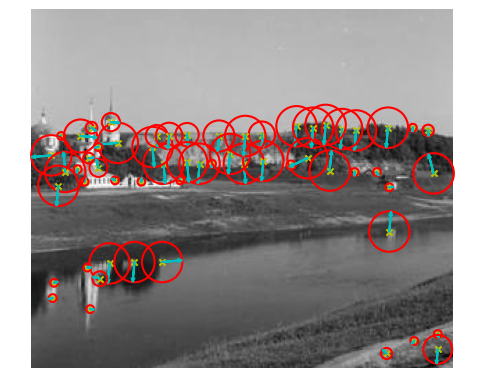

Image, 00351v: 130 corners


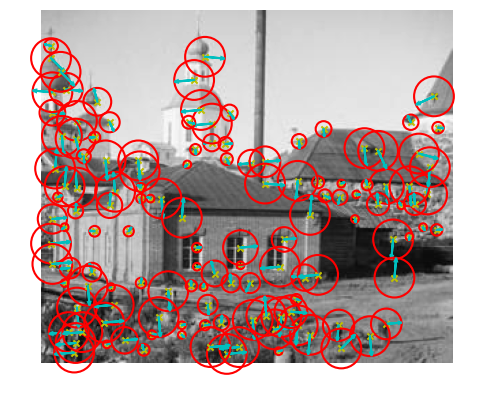

Image, 00398v: 80 corners


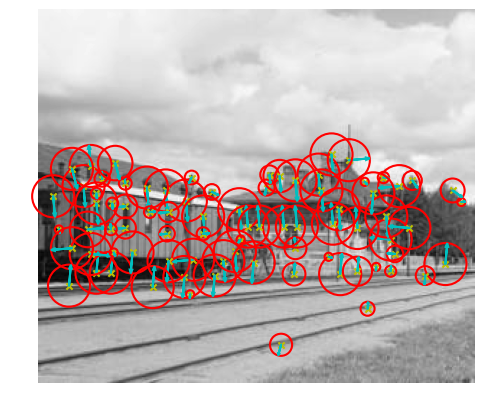

Image, 01047u: 750 corners


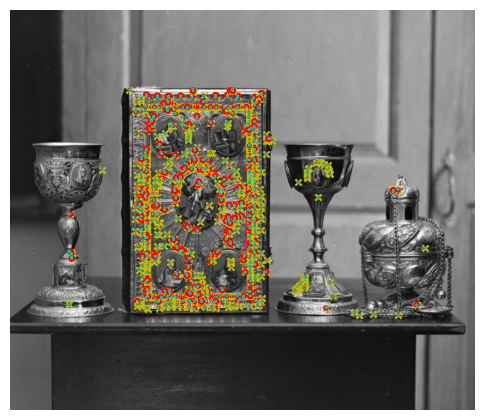

In [56]:
for name, image in selected_images_dict.items():
    img_gray = image
    coords = blob_scale_results[name]["coords"]
    sigmas_refined = blob_scale_results[name]["scales"]
    orientations = blob_scale_results[name]["orientations"]

    print(f"Image, {name}: {len(coords)} corners")  # Print number of corners

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_gray, cmap='gray')
    ax.axis('off')
    overlay_x_circle_arrow(
        ax,
        corners_rc=coords,
        sigmas=sigmas_refined,
        thetas=orientations,
        radius_factor=np.sqrt(2.0)
    )
    plt.show()

In [57]:
def shift_image_left_and_crop(image, fraction=0.20):
    """
    Shift the image to the LEFT by a given fraction of its width and crop to original size.

    Args:
        image (ndarray): 2D numpy array (grayscale image).
        fraction (float): Fraction of the width to shift left (default 0.20).

    Returns:
        ndarray: Shifted and cropped image of the same shape as input.
    """
    H, W = image.shape
    shift = int(round(fraction * W))
    canvas = np.zeros_like(image)
    canvas[:, :-shift] = image[:, shift:]
    return canvas

def shift_image_right_and_crop(image, fraction=0.20):
    """
    Shift the image to the RIGHT by a given fraction of its width and crop to original size.

    Args:
        image (ndarray): 2D numpy array (grayscale image).
        fraction (float): Fraction of the width to shift right (default 0.20).

    Returns:
        ndarray: Shifted and cropped image of the same shape as input.
    """
    H, W = image.shape
    shift = int(round(fraction * W))
    canvas = np.zeros_like(image)
    canvas[:, shift:] = image[:, :-shift]
    return canvas

def rotate_image_ccw_90(image):
    """
    Rotate the image 90 degrees counterclockwise.

    Args:
        image (ndarray): 2D numpy array (grayscale image).

    Returns:
        ndarray: Rotated image.
    """
    return np.rot90(image, k=1)

def rotate_image_cw_90(image):
    """
    Rotate the image 90 degrees clockwise.

    Args:
        image (ndarray): 2D numpy array (grayscale image).

    Returns:
        ndarray: Rotated image.
    """
    return np.rot90(image, k=-1)

def scale_image_2x_and_center_crop(image):
    """
    Enlarge the image by a factor of 2 and center-crop back to original size.

    This operation keeps the field-of-view consistent with the assignment requirements.

    Args:
        image (ndarray): 2D numpy array (grayscale image).

    Returns:
        ndarray: Scaled and center-cropped image of the same shape as input.
    """
    H, W = image.shape
    enlarged = resize(image, (2 * H, 2 * W), order=1, anti_aliasing=True, preserve_range=True)
    y0 = (2 * H - H) // 2
    x0 = (2 * W - W) // 2
    return enlarged[y0:y0 + H, x0:x0 + W]

In [58]:
# List of all transformation functions to test
transformations = [
    ("shift_left", shift_image_left_and_crop),
    ("shift_right", shift_image_right_and_crop),
    ("rotate_ccw_90", rotate_image_ccw_90),
    ("rotate_cw_90", rotate_image_cw_90),
    ("scale_2x_center_crop", scale_image_2x_and_center_crop),
]

00125v [shift_left]: 44 corners


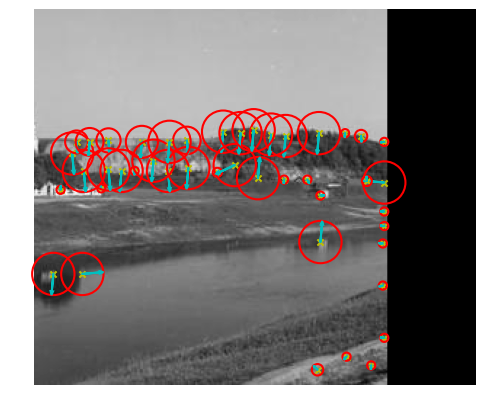

00351v [shift_left]: 90 corners


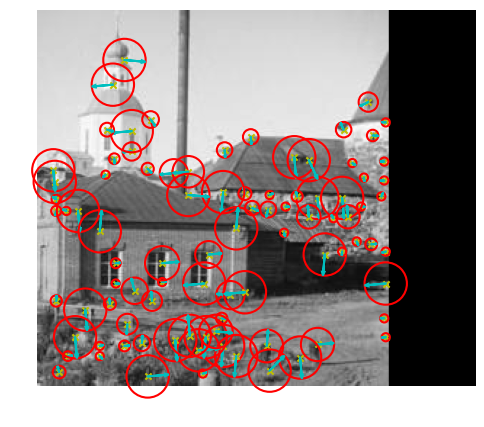

00398v [shift_left]: 64 corners


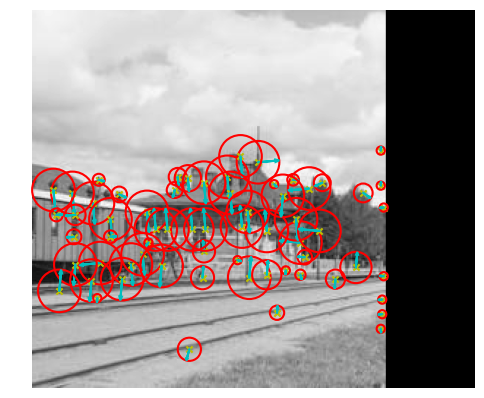

01047u [shift_left]: 750 corners


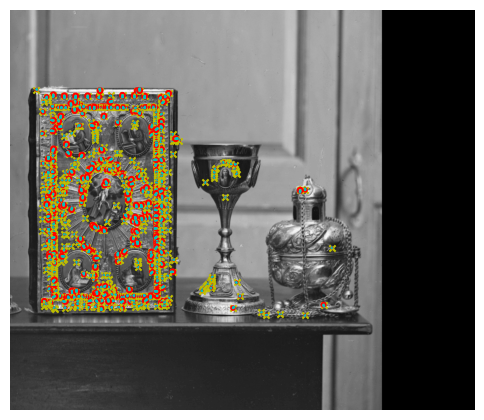

00125v [shift_right]: 52 corners


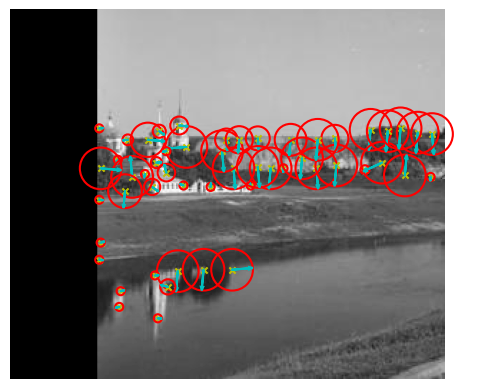

00351v [shift_right]: 110 corners


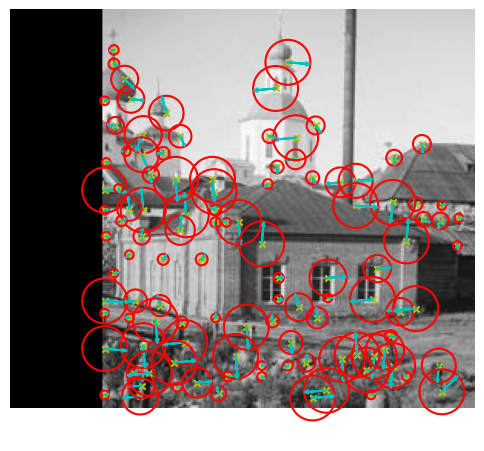

00398v [shift_right]: 75 corners


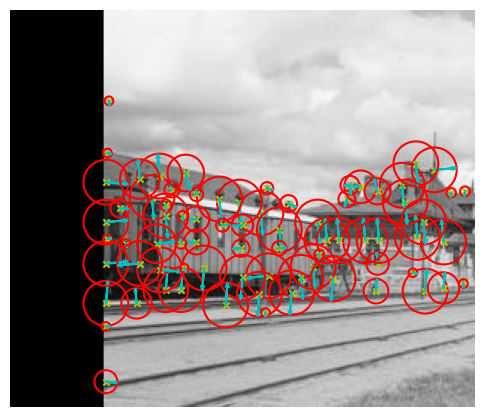

01047u [shift_right]: 750 corners


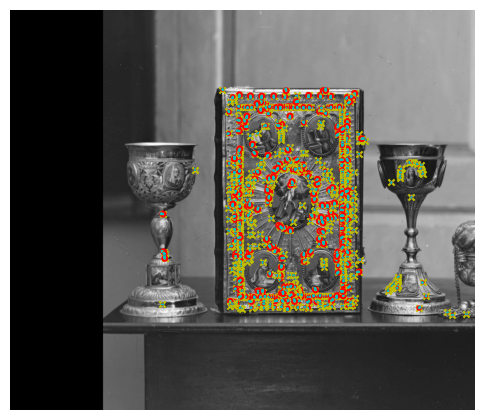

00125v [rotate_ccw_90]: 58 corners


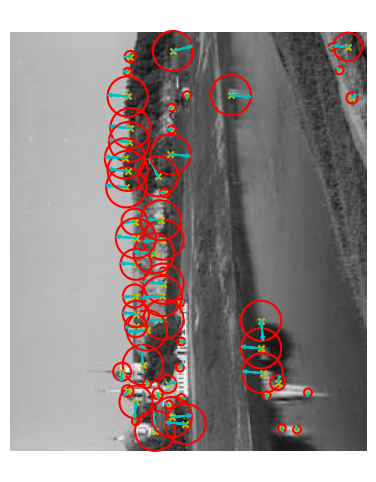

00351v [rotate_ccw_90]: 130 corners


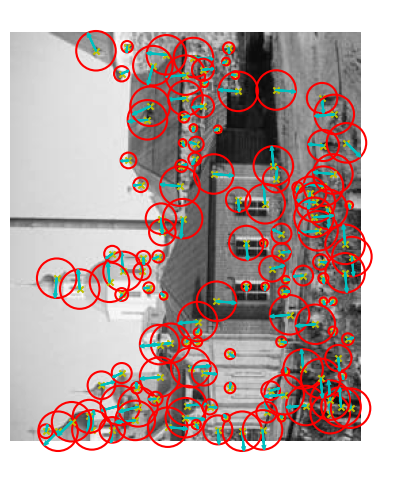

00398v [rotate_ccw_90]: 80 corners


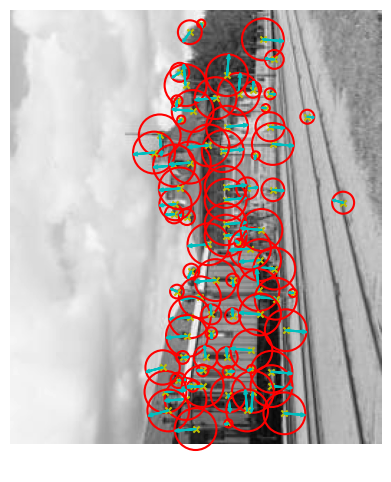

01047u [rotate_ccw_90]: 750 corners


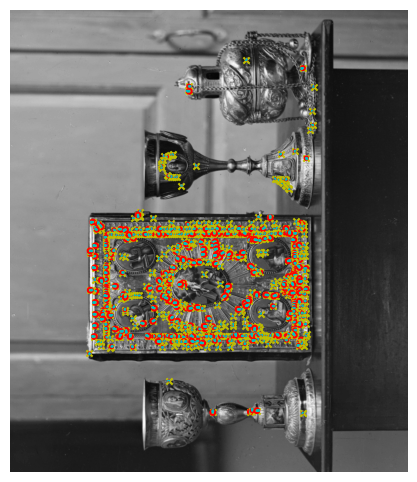

00125v [rotate_cw_90]: 58 corners


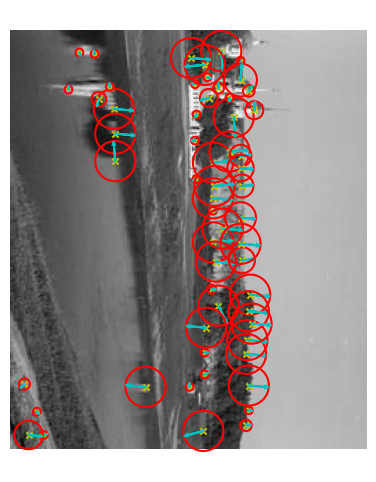

00351v [rotate_cw_90]: 130 corners


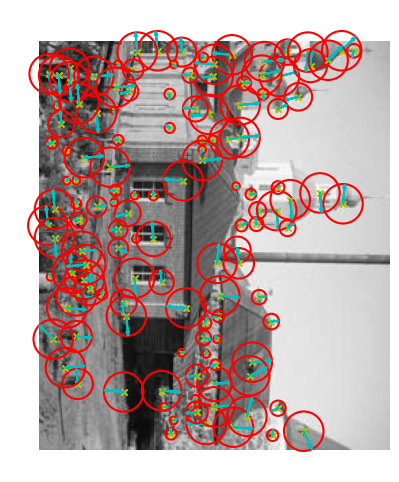

00398v [rotate_cw_90]: 80 corners


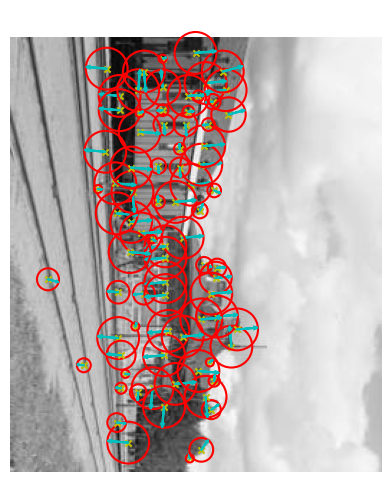

01047u [rotate_cw_90]: 750 corners


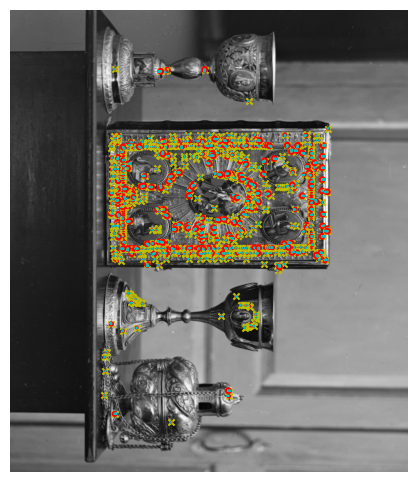

00125v [scale_2x_center_crop]: 52 corners


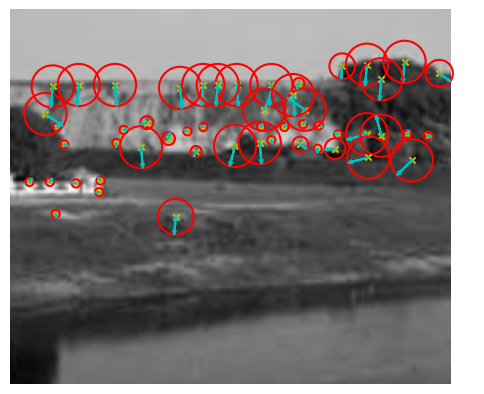

00351v [scale_2x_center_crop]: 79 corners


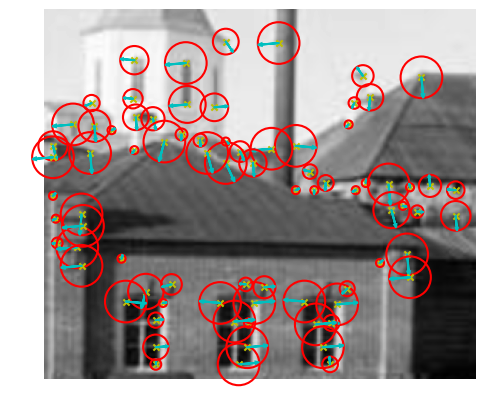

00398v [scale_2x_center_crop]: 101 corners


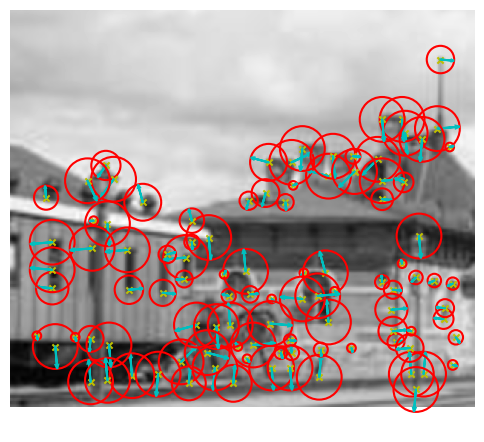

01047u [scale_2x_center_crop]: 750 corners


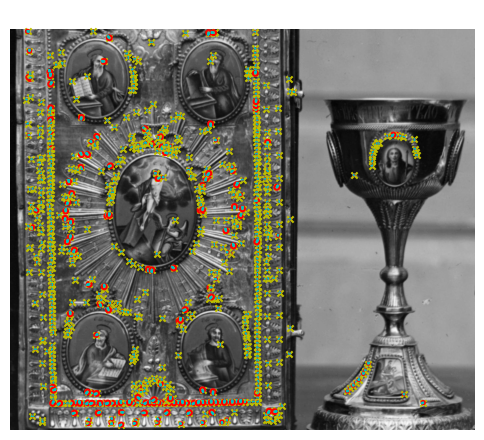

In [59]:
for tname, tfunc in transformations:
    for name, image in selected_images_dict.items():
        # 1. Apply transformation
        transformed_image = tfunc(image)
        # 2. Harris corner detection
        harris_response, transformed_corners = harris_corner_detector(
            transformed_image, **harris_configs
        )
        # 3. LoG blob scale detection
        sigmas_refined, best_levels, best_values = detect_blob_scales(
            image=transformed_image,
            corner_coords=transformed_corners,
            sigma0=2.0,
            k=1.2,
            num_levels=10,
            return_stack=False
        )
        # 4. Orientation assignment
        orientations = dominant_orientations(
            img_gray=transformed_image,
            corner_coords=transformed_corners,
            scales=sigmas_refined,
            radius_factor=np.sqrt(2.0),
            num_bins=36
        )
        # 5. Print stats and visualize
        print(f"{name} [{tname}]: {len(transformed_corners)} corners")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(transformed_image, cmap='gray')
        ax.axis('off')
        overlay_x_circle_arrow(
            ax,
            corners_rc=transformed_corners,
            sigmas=sigmas_refined,
            thetas=orientations,
            radius_factor=np.sqrt(2.0)
        )
        plt.show()